# OCC time EDA

EDA en tiempo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
spark = SparkSession \
    .builder \
    .appName("occ_time_eda") \
    .getOrCreate()

#filename = "occ-timeseries.jsonl"
filename = "occ-timeseries-real.jsonl" #real: solo vacantes no agregadas

base_dir = f"harvester/occ/"
df = spark.read.json(f"{base_dir}/{filename}")

In [3]:
df.printSchema()

root
 |-- confidenciales: long (nullable = true)
 |-- count_by_category: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- category_id: long (nullable = true)
 |    |    |-- count: long (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- pct: double (nullable = true)
 |-- count_by_company_url: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: long (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- count_by_company_where_not_redirected: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: long (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- count_by_company_where_redirected: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- count_by_granular_location: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: long (nullable = true)
 |  

In [4]:
df_c = df.withColumn("day", F.to_date(F.col("date"), "yyyyMMdd"))
df_c.select('day').collect()

[Row(day=datetime.date(2023, 7, 14)),
 Row(day=datetime.date(2023, 7, 24)),
 Row(day=datetime.date(2023, 8, 2)),
 Row(day=datetime.date(2023, 8, 8)),
 Row(day=datetime.date(2023, 8, 21)),
 Row(day=datetime.date(2023, 8, 30)),
 Row(day=datetime.date(2023, 9, 12)),
 Row(day=datetime.date(2023, 9, 20)),
 Row(day=datetime.date(2023, 9, 25)),
 Row(day=datetime.date(2023, 10, 2)),
 Row(day=datetime.date(2023, 10, 10)),
 Row(day=datetime.date(2023, 10, 17)),
 Row(day=datetime.date(2023, 10, 23)),
 Row(day=datetime.date(2023, 10, 30)),
 Row(day=datetime.date(2023, 11, 13)),
 Row(day=datetime.date(2023, 11, 15)),
 Row(day=datetime.date(2023, 11, 17))]

,day,deduplicated_real_record_count
0,2023-07-14,84658
1,2023-07-24,79659
2,2023-08-02,78558
3,2023-08-08,78332
4,2023-08-21,79529
5,2023-08-30,79747
6,2023-09-12,78912
7,2023-09-20,78338
8,2023-09-25,78537
9,2023-10-02,76569


<Axes: xlabel='day'>

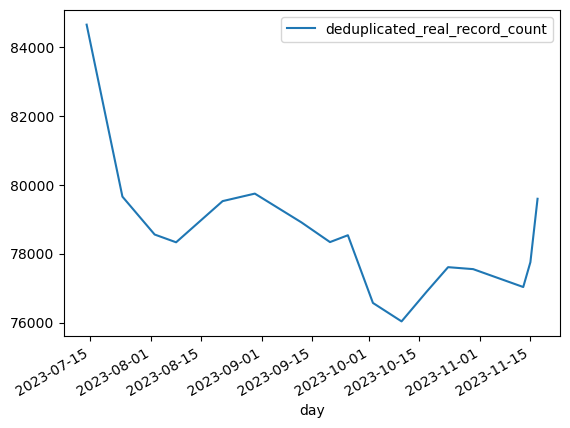

In [5]:
df_c = df_c.select(["day", "deduplicated_real_record_count"]).toPandas()
df_c["day"] = pd.to_datetime(df_c["day"], format="%Y-%M-%d")
display(df_c)
df_c.set_index("day").plot()

### Estados

In [6]:
#df.createOrReplaceTempView("data")
#spark.sql("select count_by_state from data").show()
#df.select(F.explode(F.col("count_by_state"))).select(["col.count", "col.description"]).show()#.select(["description", "count"]).show()
states = df.select(["day", "count_by_state"])\
    .withColumn("exp", F.explode(F.col("count_by_state")))\
    .select(["day", "exp.count", "exp.description"])#.show(100)#.select(["description", "count"]).show()
#df.select(F.struct("count_by_state.count", "count_by_state.description")).show()
states = states.groupby("day").pivot("description").sum().orderBy(F.col("day")).toPandas().set_index("day").transpose()
states

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `day` cannot be resolved. Did you mean one of the following? [`date`, `confidenciales`, `salary_summary`, `count_by_state`, `record_version`].;
'Project ['day, count_by_state#17]
+- Relation [confidenciales#8L,count_by_category#9,count_by_company_url#10,count_by_company_where_not_redirected#11,count_by_company_where_redirected#12,count_by_granular_location#13,count_by_jobType#14,count_by_jobType_redirect_type#15,count_by_redirect_type#16,count_by_state#17,count_by_subcategory#18,date#19,deduplicated_real_record_count#20L,proportions_by_category_by_redirect_type#21,record_version#22,salary_summary#23,total_record_count#24L] json


In [ ]:
states.transpose().plot(legend=False)

In [ ]:
df.select(["day", "count_by_redirect_type"]).select("day", F.posexplode_outer(F.col("count_by_redirect_type")))\
.groupby(["day", "pos", "col"]).sum().show()
    #.select(F.explode_outer(F.col("exp"))).show()
    #.toPandas()#.show(33)

### Por tipo de redireccionamiento

- 0: No redireccionadas
- 1: ? (¿redireccionamiento pagado?)
- 2: Redir fuera del sitio (¿son agregadas?)

In [ ]:
dfu.groupby("redirect.type").count().show()

### Por tipo de anuncio
Tablas para todas las vacantes y paras las únicas. 

Notar que las Premium parecen tener mas duplicadas, puede ser por el proceso de scraping cuando aparecen en varios SERP

In [ ]:
df.groupby("jobType").count().show()

In [ ]:
dfu.groupby("jobType").count().show()

### Tipo de Anuncio / redireccionamiento

CLASSIC / Redir=2 => Suponemos que son las agregadas

In [ ]:
dfu.groupby("jobType").pivot("redirect.type").count().show()

#### Proporciones por JobType

In [ ]:
pdf = dfu.groupby("jobType").pivot("redirect.type").count().toPandas().fillna(0).set_index('jobType')
pdf.columns = ['NoRedir', 'Redir1', 'Redir2']
pdf.div(pdf.sum(axis=1), axis=0)

#### Proporciones por tipo de redir

Esto demostraría que las Redir2 son agregadas no pagadas ya que practicamente todas son clásicas

In [ ]:
pdf.div(pdf.sum(axis=0), axis=1)

#### Proporciones del total

In [ ]:
pdf.div(pdf.sum().sum())

## Categorias

### Totales

In [ ]:
cat_count = dfu.groupby("category").count().orderBy(F.col("count").desc())
split_col = F.split(cat_count["category.__ref"].cast("String"), ":")
cat_count = cat_count.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count = cat_count.join(categories.select("id", "description"), cat_count.category_id == categories.id, how="inner")
cat_count = cat_count.select(["category_id", "description", "count"]).orderBy(F.col("count").desc())

In [ ]:
cat_count = cat_count.withColumn("pct", F.col("count") / record_count)
cat_count.show(cat_count.count(), truncate=False)

### Proporciones por tipo de Redir

In [ ]:
split_col = F.split(dfu["category.__ref"].cast("String"), ":")
cat_count_redir = dfu.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count_redir = cat_count_redir.groupby("category_id").pivot("redirect.type").count()
cat_count_redir = cat_count_redir.join(categories.select("id", "description"), cat_count_redir.category_id == categories.id, how="inner")
cat_count_redir = cat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
cat_count_redir.columns = ["Category", "NoRedir", "Redir1", "Redir2"]
cat_count_redir = cat_count_redir.set_index("Category")
cat_count_redir = cat_count_redir.div(cat_count_redir.sum(axis=1), axis=0)
cat_count_redir

#### Categorías en las que OCC es débil

Mayor proporción de agregadas

In [ ]:
cat_count_redir.sort_values("Redir2", ascending=False)

## Subcategorías

In [ ]:
subcat_count = dfu.groupby("subcategory").count().orderBy(F.col("count").desc())
split_col = F.split(subcat_count["subcategory.__ref"].cast("String"), ":")
subcat_count = subcat_count.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count = subcat_count.join(subcategories.select("id", "description"), subcat_count.subcategory_id == subcategories.id, how="inner")
subcat_count.orderBy(F.col("count").desc()).show(25, truncate=False)

In [ ]:
split_col = F.split(dfu["subcategory.__ref"].cast("String"), ":")
subcat_count_redir = dfu.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count_redir = subcat_count_redir.groupby("subcategory_id").pivot("redirect.type").count()
subcat_count_redir = subcat_count_redir.join(subcategories.select("id", "description"), subcat_count_redir.subcategory_id == subcategories.id, how="inner")
subcat_count_redir = subcat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
subcat_count_redir.columns = ["subcategory", "NoRedir", "Redir1", "Redir2"]
subcat_count_redir = subcat_count_redir.set_index("subcategory")
subcat_count_redir = subcat_count_redir.div(subcat_count_redir.sum(axis=1), axis=0)
pd.set_option('display.max_rows', None)
subcat_count_redir

In [ ]:
subcat_count_redir.sort_values("Redir2", ascending=False)

## Google For Jobs

- Primer campo: si la oferta está disponible para G4J
- Segundo campo: (¿?) si la oferta ya está indexada por G4J

In [ ]:
dfu.groupby("googleForJobs").count().sort(F.col("count").desc()).show(truncate=False)

## Ubicación

### Estados

#### Distribución de vacantes por estado con suma acumulada

In [ ]:
dfu_loc = dfu.select("id", F.explode("location.locations").alias("loc_data"))
state_count = dfu_loc.groupby("loc_data.state.description").count().sort(F.col("count").desc())
state_count_p = state_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
state_count_p = state_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
state_count_p.show(33)

#### Vacantes por estado divididas por tipo Redir, con histograma para Redir2

In [ ]:
state_count = dfu.withColumn("loc_data", F.explode("location.locations"))\
                .groupby("loc_data.state.description")\
                .pivot("redirect.type").count()\
                .withColumn("total", F.col("0") + F.col("1") + F.col("2"))\
                .withColumn("NoRedirPct", F.col("0") / F.col("total"))\
                .withColumn("Redir1Pct", F.col("1") / F.col("total"))\
                .withColumn("Redir2Pct", F.col("2") / F.col("total"))\
                .sort(F.col("total").desc())

In [ ]:
state_count.show()

In [ ]:
state_count_pd = state_count.toPandas()
print(state_count_pd["Redir2Pct"].describe())
state_count_pd["Redir2Pct"].hist(bins=15)

#### Descripción (granular)

In [ ]:
loc_count = dfu.groupby("location.description").count().sort(F.col("count").desc())
loc_count_p = loc_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
loc_count_p = loc_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
print(f"Número de location.description: {loc_count_p.count()}")
loc_count_p.show(30, truncate=False)

In [ ]:
loc_count_p.toPandas()["cumsum"].plot()

## Compañias

Basadas en la url. 

NULL ==> Confidenciales

In [ ]:
company_count = dfu.groupby("company.url").count().sort(F.col("count").desc())
print(f"Número de URLs de compañias: {company_count.count()}")
company_count.show(25, truncate=False)

#### Proporción de vacantes por cia y suma acumulada

In [ ]:
ccp = company_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
ccp.withColumn("cumsum", F.sum(F.col("perc")).over(window)).show(30, truncate=False)

### Excluyendo confidenciales

In [ ]:
ccp_noconf = company_count.where("url is not null")
nconf_records = ccp_noconf.agg(F.sum("count")).collect()[0][0]
ccp_noconf = ccp_noconf.withColumn("perc", F.col("count") / nconf_records).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
ccp_noconf.withColumn("cumsum", F.sum(F.col("perc")).over(window)).show(30, truncate=False)

### Confidenciales

La URL null son confidenciales

In [ ]:
dfu.select(["company.url", "company.name"]).where("company.confidential=TRUE").count()

In [ ]:
dfu.select("company.url").where("company.confidential=TRUE").distinct().count()

### URLs con minusculas -> agregadas

Al parecer las vacantes que tienen company.url en minusculas pero igual a otra URL son de vacantes agregadas

In [ ]:
dfu.where("company.url='empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/'").count()

In [ ]:
company_count = dfu.where("redirect.type != 2").groupby("company.url").count().sort(F.col("count").desc())
company_count.show(truncate=False)

In [ ]:
company_count = dfu.where("redirect.type == 2").groupby("company.url").count().sort(F.col("count").desc())
company_count.show(truncate=False)

Hay que revisar qué nos dicen estos datos para inferir mejor 

In [ ]:
dfu.where("redirect.isRedirected == TRUE").where("autoinclusion.autoinclusion == TRUE").count()

In [ ]:
dfu.where("redirect.isRedirected == TRUE").where("autoinclusion.autoinclusion == FALSE").count()

In [ ]:
dfu.where("redirect.isRedirected == FALSE").where("autoinclusion.autoinclusion == TRUE").count()

In [ ]:
dfu.where("redirect.isRedirected == FALSE").where("autoinclusion.autoinclusion == FALSE").count()

In [ ]:
dfu.where("redirect.isRedirected == TRUE")\
    .where("autoinclusion.autoinclusion == TRUE")\
    .select(["scraped_url", "redirect.externalUrl"])\
    .show(truncate=False)

## Salarios

In [ ]:
dfu.select(["salary.from", "salary.to"]).summary().show()

Casi todas las Redir2 (agregadas) no tienen salario, vs 1/3 de las pagadas:

In [ ]:
dfu.withColumn("has_salary", F.col("salary.from") != 0).groupby("redirect.type").pivot("has_salary").count().show()

Al parecer si alguno de los dos campos de salario es mayor a 0, el otro también lo es

In [ ]:
salary = dfu.select(["salary.from", "salary.to"]).where("salary.from > 0 or salary.to > 0")
salary = salary.withColumn("avg", (F.col("from") + F.col("to")) / 2)
salary.summary().show()

In [ ]:
#seleccionar rangos para eliminar outliers - los percentiles son ajustados a algo que permita comparar con CT
outlier_limits = salary.select(F.percentile_approx("avg", [0.009, 0.9995]))
outlier_min, outlier_max = outlier_limits.collect()[0][0]
outlier_limits.show()

In [ ]:
salary = salary.where(f"avg >= {outlier_min} and avg <= {outlier_max}")
salary.summary().show()

Esto es solo para extraer jobids que va a ser usados despues

In [ ]:
with open("occ_jobids_1.txt", "w") as fo:
    [fo.write(f"{y}\n") for y in dfu.select("id").sort(F.col("id").cast("int").desc()).limit(10000).rdd.flatMap(lambda x: x).collect()]